In [1]:
# IMPORTS AND SETUP

import torch as pytorch
import matplotlib as plt
import numpy as np
import torchvision
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.nn import functional
from torch.nn import AvgPool2d
from sklearn.metrics import confusion_matrix
import seaborn as sns 

import torch
from tqdm import trange

DEVICE = 'cuda' if pytorch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
pytorch.backends.cudnn.deterministic = True
pytorch.backends.cudnn.benchmark = False
pytorch.manual_seed(seed)


lr = 0.01
max_epochs=20
gamma = 0.95

log_interval = 100

In [2]:
# DATA INTAKE AND REGULARIZATION

data_directory = 'facial_expression/'

# We will not need to transform a lot, as it is already 48x48 pixels
# We can try different transform methods, such as flipping.
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            
                                   torchvision.transforms.Normalize([0.5, 0.5, 0.5],
                                                                   [0.5, 0.5, 0.5])
                                           ])

dataset_train = datasets.ImageFolder(data_directory + 'train', transform=transform)
dataset_test = datasets.ImageFolder(data_directory + 'test', transform=transform)

train_loader = pytorch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = pytorch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

happy


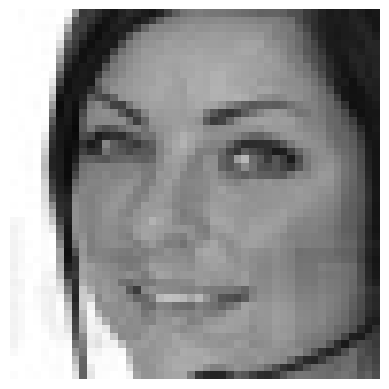

In [3]:
# Sample Image
# plotting image

%matplotlib inline

expression_dictionary = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 
                         5: 'sad', 6: 'surprise'}

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(iter(train_loader))
imshow(images[4])
print(expression_dictionary[int(labels[4])])

train_loader = pytorch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = pytorch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [4]:
# Training and Testing Functions
batch_size = 32

# Setting up the training functions
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    # Sets the model to training mode
    model.train()
    losses = []
    counter = []
    
    # For each batch
    for i, (img, label) in enumerate(train_loader):
        # Get the image, and the label
        img, label = img.to(device), label.to(device)
        # resets the optimizer
        optimizer.zero_grad()
        # Get the prediction
        output = model(img)
        
#         print("True Label: ", label)
#         print("Predict: ", output)
        
        # calculate the training loss
        loss = functional.nll_loss(output, label)
        # Backpropagate
        loss.backward()
        # Step forward in the next step
        optimizer.step()

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter


def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)
            pred = output.max(1)[1] # Get index of largest log-probability and use that as prediction
            num_correct += pred.eq(label).sum().item()
            test_loss /= len(test_loader)
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [50]:
# Graph Functions

# Loss Curve for Graphs
# 1. Draw training loss curve
def draw_loss_curve(train_counter, train_losses, test_losses, title):
    fig = plt.figure(figsize=(12,8))
    plt.plot(train_counter, train_losses, label='Train loss')
    plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
             test_losses, label='Test loss', marker='o')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=24)
    plt.xlabel('Number of training examples seen', fontsize=16)
    plt.ylabel('NLL', fontsize=16)
    plt.legend(loc='upper right', fontsize=14)
    
def confusion_matrix(model):
    # Get the true labels and predicted labels for the validation set
    train_loader = pytorch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
    test_loader = pytorch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

    test_labels = test_loader.classes
    test_pred_probs = model.predict(test_loader)
    test_pred_labels = np.argmax(test_pred_probs, axis=1)

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(test_labels, test_pred_labels)
    class_names = list(train_loader.class_indices.keys())
    sns.set()
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
def show_first_batch(model):
    # 2. Show the predictions of the first 10 images of the test dataset
    images, labels = next(iter(test_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    output = model(images)
    pred = output.argmax(dim=1)

    # ------------------
    import numpy as np
    for i in range(10):

        imshow(images[i])
        print("Actual: ", expression_dictionary[int(labels[i])])
        print("Predicted: ", expression_dictionary[int(pred[i])])
    # ------------------

In [33]:
# Training And Testing Function
def train_test(model):
    train_loader = pytorch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
    test_loader = pytorch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
    # Recording data
    log_interval = 100

    # Instantiate optimizer (model was created in previous cell)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    train_counter = []
    test_losses = []
    test_correct = []
    for epoch in trange(max_epochs, leave=True, desc='Epochs'):
        train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
        test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)

        # Record results
        train_losses.extend(train_loss)
        train_counter.extend(counter)
        test_losses.append(test_loss)
        test_correct.append(num_correct)

    print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
    
    return train_losses, train_counter, test_losses, test_correct

## Base Model: LeNetMax
This is our base model, with no Dropouts, and two Convolutional-Pooling Layers. Kernel Size will be (5,5), and will be connected to a final Feedforward Neural Network that will produce the softmax of our solution.

The architechture is:

for Stride length == 2:
Input: (3, 48, 48) -> Conv2d: (32, 44, 44) -> Max Pool: (32, 22, 22) -> Conv2d: (64, 18, 18) -> Max Pool: (64, 9, 9) -> Flatten (64 * 9 * 9) -> 600 -> ReLU -> Linear (600, 7) -> Softmax



In [2]:
class LeNetMax(Module):
    def __init__(self, num_channels, num_classes, stride_length):
        super().__init__()
        self.conv1 = Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        # second layer
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        # calculating the inputs size
        # (48 - 5) + 1 = 44
        # (44 - 2) / 2 = 21 + 1 = 22
        # (22 - 5) + 1 = 18
        # (18 - 2) / 2 = 8 + 1 = 9
        input_size = (48 - 5) + 1
        input_size = (input_size - 2) / stride_length + 1
        input_size = (input_size - 5) + 1
        input_size = (input_size - 2) / stride_length + 1
        
        final_size = input_size * input_size * 64
        
        self.fc1 = Linear(int(final_size), 600)
        self.relu3 = ReLU()
        
        self.fc2 = Linear(600, num_classes)
        self.num_classes = num_classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        return functional.log_softmax(x, dim=1)
    

NameError: name 'Module' is not defined

## Base Model: LeNetAvg
This will be our second base model, but instead of max pooling, we will do average pooling instead


In [8]:
class LeNetAvg(Module):
    def __init__(self, num_channels, num_classes, stride_length):
        super().__init__()
        self.conv1 = Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = AvgPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        # second layer
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = AvgPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        # calculating the inputs size
        # (48 - 5) + 1 = 44
        # (44 - 2) / 2 = 21 + 1 = 22
        # (22 - 5) + 1 = 18
        # (18 - 2) / 2 = 8 + 1 = 9
        input_size = (48 - 5) + 1
        input_size = (input_size - 2) / stride_length + 1
        input_size = (input_size - 5) + 1
        input_size = (input_size - 2) / stride_length + 1
        
        final_size = input_size * input_size * 64
        
        self.fc1 = Linear(int(final_size), 600)
        self.relu3 = ReLU()
        
        self.fc2 = Linear(600, num_classes)
        self.num_classes = num_classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        return functional.log_softmax(x, dim=1)

## Stronger Model
We will reduce the kernel size to 3,3 and add one extra layer. We will be padding. We will still not be doing any Batch Normalization or dropouts yet. We will do Max Pooling.

Input: (3, 48, 48) -> Conv2d (32, 48, 48) -> Pooling (32, 24, 24) -> Conv2d (64, 24, 24) -> pooling (64, 12, 12) -> conv2d (128, 12, 12) -> pooling (128, 6, 6) -> Flatten



In [9]:
class StrongCNN(Module):
    def __init__(self, num_channels, num_classes, stride_length):
        super().__init__()
        self.conv1 = Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 3), padding='same')
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same')
        self.relu3 = ReLU()
        self.maxpool3 = MaxPool2d(kernel_size=(2, 2), stride=(stride_length, stride_length))
        
        input_size = 128 * 6 * 6
        
        self.fc1 = Linear(int(input_size), 1024)
        self.relu4 = ReLU()
        
        self.fc2 = Linear(1024, num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)
        return functional.log_softmax(x, dim=1)

## Strongest Model
We will reduce the kernel size to 3,3, we will pair 2 conv layers with 1 pooling layer, and we will be doing batch regularization and dropout. 

In [10]:
from torch.nn import BatchNorm2d
from torch.nn import Dropout

class StrongestCNN(Module):
    def __init__(self, num_channels, num_classes, stride_length):
        super().__init__()
        
        self.conv1 = Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 3), padding='same')
        self.relu1 = ReLU()
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same')
        self.relu2 = ReLU()
        self.batchNorm1 = BatchNorm2d(64)
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2))
        
        self.dropout1 = Dropout(0.25)
        
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same')
        self.relu3 = ReLU()
        self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding='same')
        self.relu4 = ReLU()
        self.batchNorm2 = BatchNorm2d(256)
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2))
        
        self.dropout2 = Dropout(0.25)
        
        self.fc1 = Linear(256 * 12 * 12, 1024)
        self.relu5 = ReLU()
        self.dropout3 = Dropout(0.25)
        
        self.fc2 = Linear(1024, 4096)
        self.relu6 = ReLU()
        self.dropout4 = Dropout(0.25)
    
        self.fc3 = Linear(4096, num_classes)
        self.num_classes=  num_classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.batchNorm1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        
        x = self.batchNorm2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
         = 
        
        return functional.log_softmax(x, dim=1)

In [11]:
# Initializing Model
base_model_max = LeNetMax(num_channels=3, num_classes=7, stride_length=2)
base_model_avg = LeNetAvg(num_channels=3, num_classes=7, stride_length=2)
strong_model = StrongCNN(num_channels=3, num_classes=7, stride_length=2)
strongest_model = StrongestCNN(num_channels=3, num_classes=7, stride_length=2)

In [13]:
import torch
# Base Model Max Training
base_max_train_loss, base_max_train_counter, base_max_test_loss, base_max_test_correct = train_test(base_model_max)
# Saving Base Model Max
torch.save(base_model_max, 'base_model_max.pt')


Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [17:12<00:00, 51.61s/it]

Test accuracy: 0.5678461967121761


In [14]:
base_avg_train_loss, base_avg_train_counter, base_avg_test_loss, base_avg_test_correct = train_test(base_model_avg)
torch.save(base_model_avg, 'base_model_avg.pt')

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [17:14<00:00, 51.73s/it]

Test accuracy: 0.46962942323767065


In [15]:
strong_train_loss, strong_train_counter, strong_test_loss, strong_test_correct = train_test(strong_model)
torch.save(strong_model, 'strong_model.pt')

Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:50<00:00, 59.54s/it]

Test accuracy: 0.4374477570353859


In [16]:
strongest_train_loss, strongest_train_counter, strongest_test_loss, strongset_test_correct = train_test(strongest_model)
torch.save(strongest_model, 'strongest_model.pt')

Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:30:53<00:00, 272.65s/it]


Test accuracy: 0.5898578991362496


## ANALYSIS

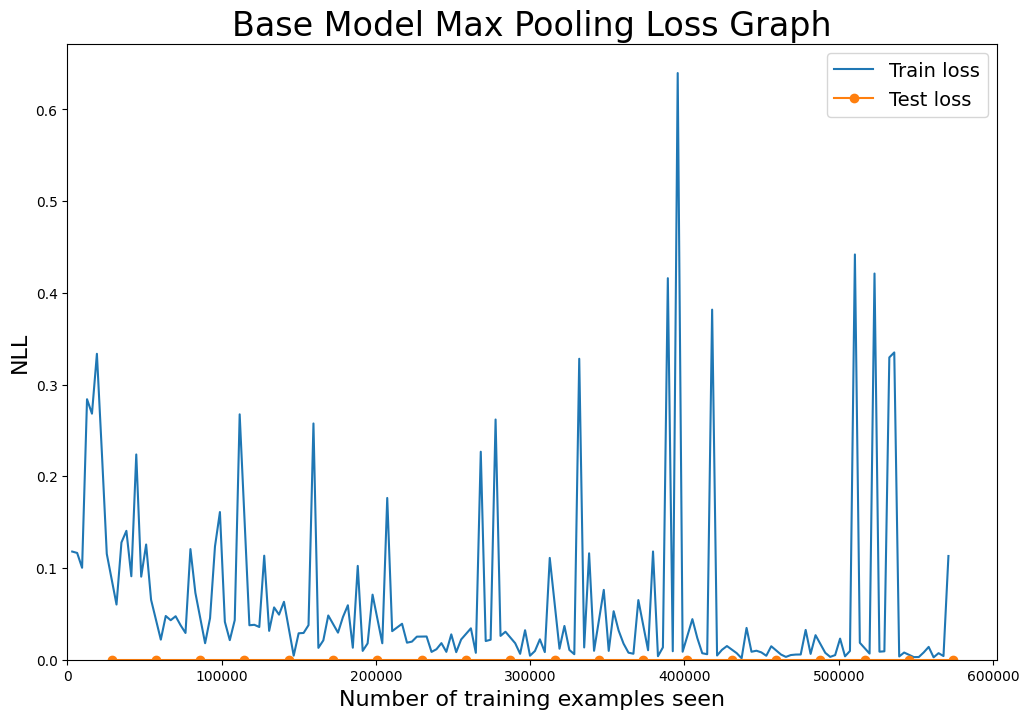

In [25]:
# Graphs of Loss:
draw_loss_curve(base_max_train_counter, base_max_train_loss, base_max_test_loss, "Base Model Max Pooling Loss Graph")

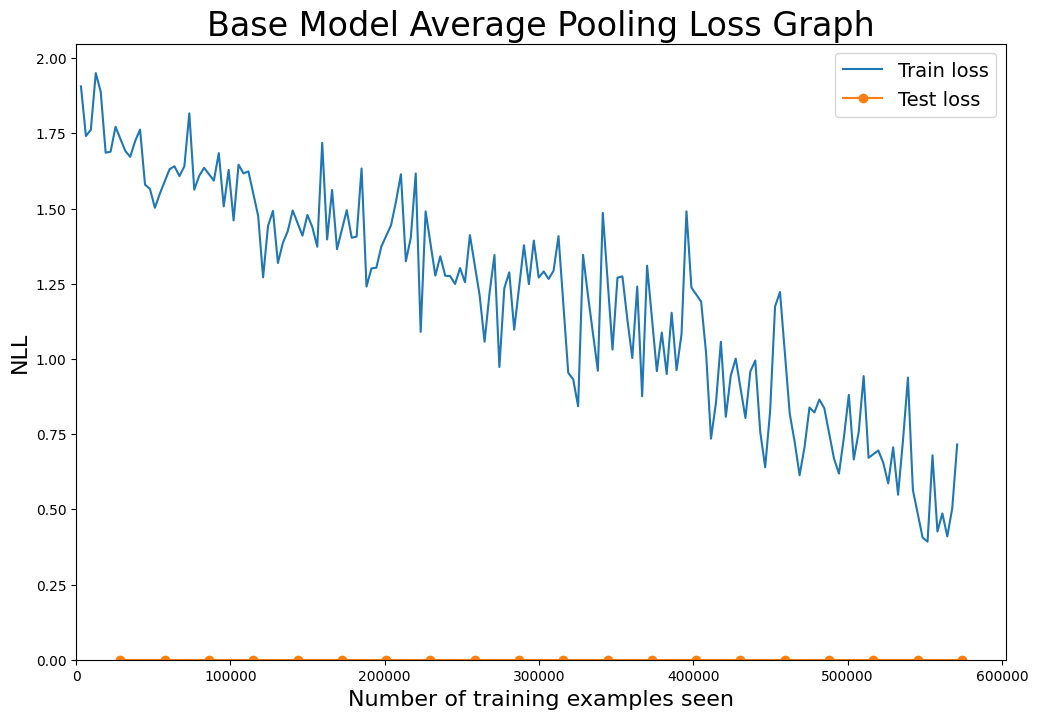

In [26]:
# Graphs of Loss:
draw_loss_curve(base_avg_train_counter, base_avg_train_loss, base_avg_test_loss, "Base Model Average Pooling Loss Graph")

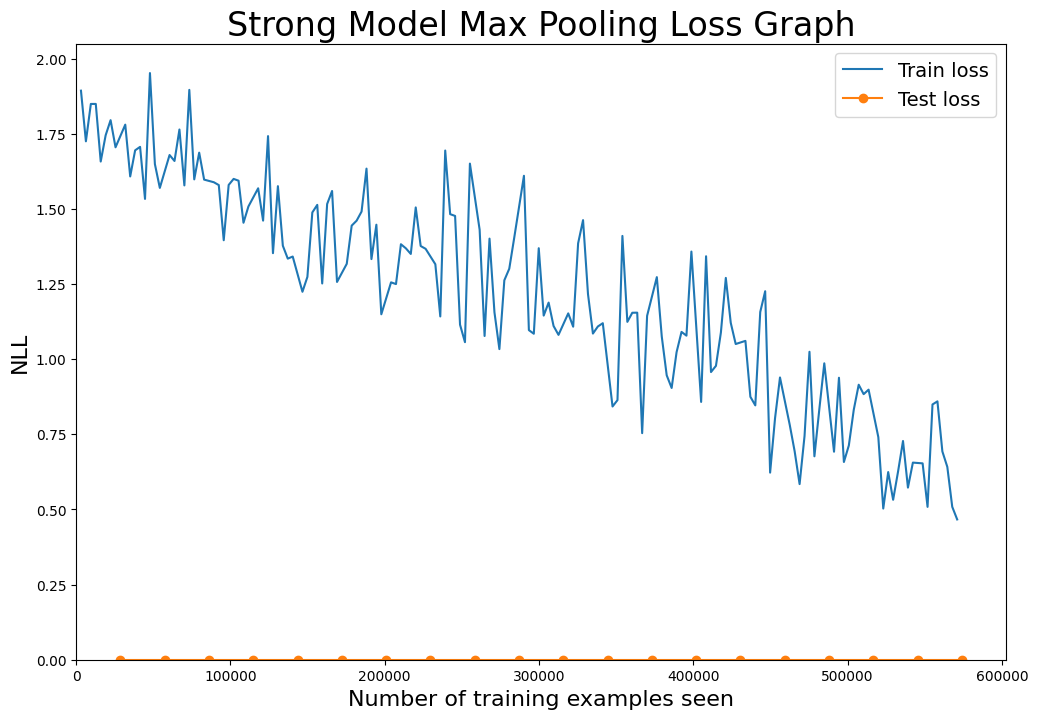

In [57]:
# Graphs of Loss:
draw_loss_curve(strong_train_counter, strong_train_loss, strong_test_loss, "Strong Model Max Pooling Loss Graph")

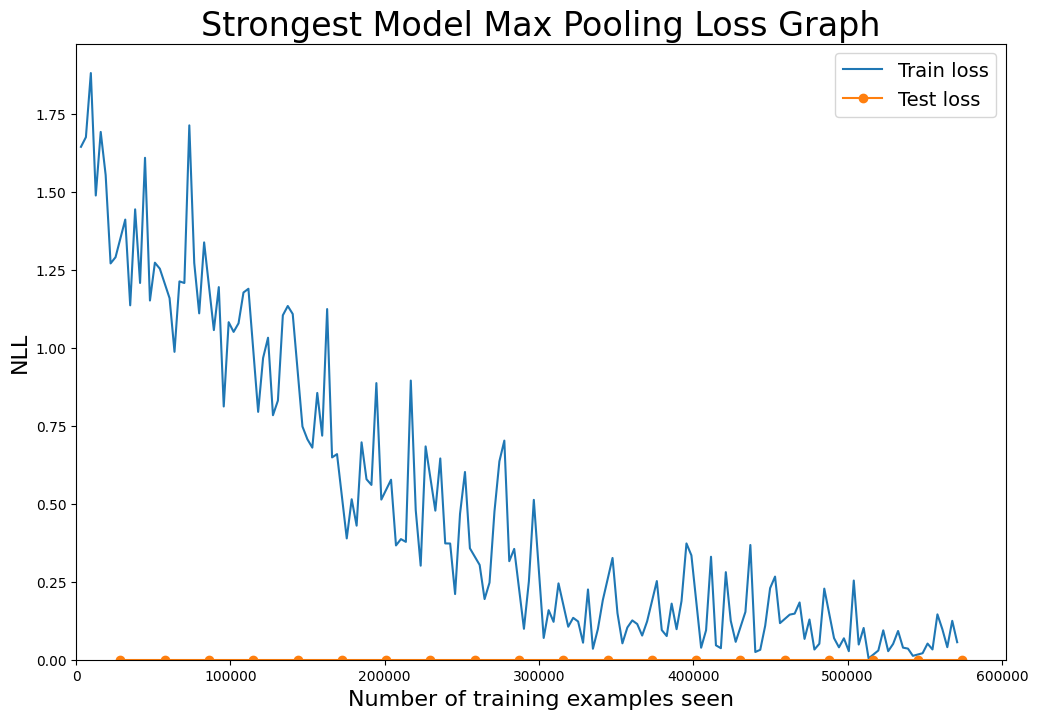

In [56]:
# Graphs of Loss:
draw_loss_curve(strongest_train_counter, strongest_train_loss, strongest_test_loss, "Strongest Model Max Pooling Loss Graph")

## LOSS GRAPH ANALYSIS
We can see that for our max pooling loss graph, we can see that we started pretty low. It basically converged to possibly optimal. However, for our other three graphs, we can see that we have a steady decline of loss. This signifies that if we were to train a little bit more, we will be able to see better accuracy in our models. Esspecially our "Strong" model, which has a steady decrease of loss per number of training examples seen. In our "Strongest" model, we see that it is very near zero. However, because of the variance, we can definitely try for more epoch's to see whether it will increase in test accuracy.

## Confusion Matrix

Actual:  sad
Predicted:  angry
Actual:  surprise
Predicted:  surprise
Actual:  fear
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  fear
Actual:  fear
Predicted:  fear
Actual:  neutral
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  sad
Predicted:  fear


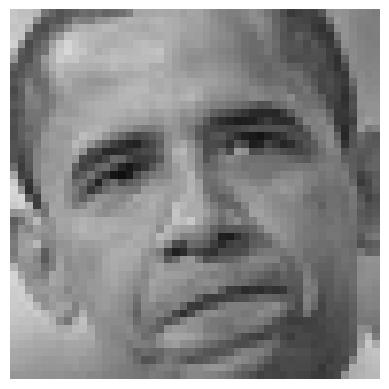

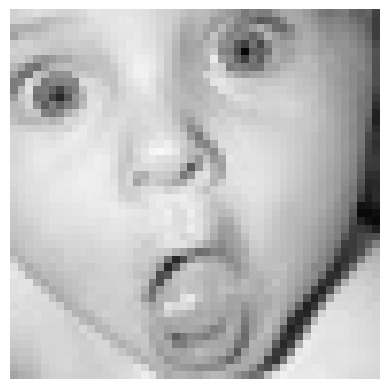

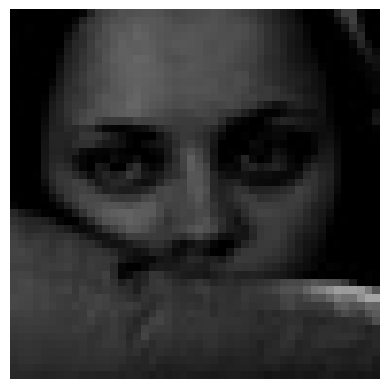

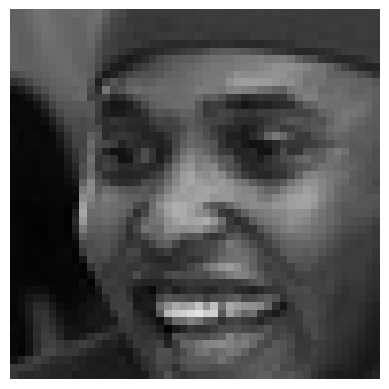

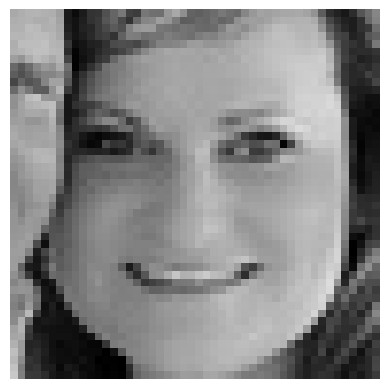

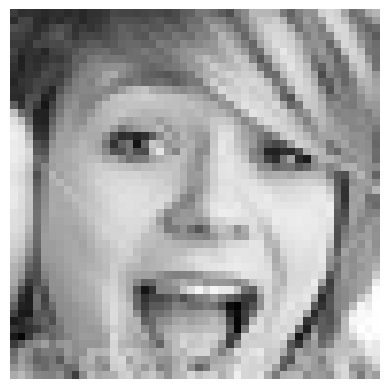

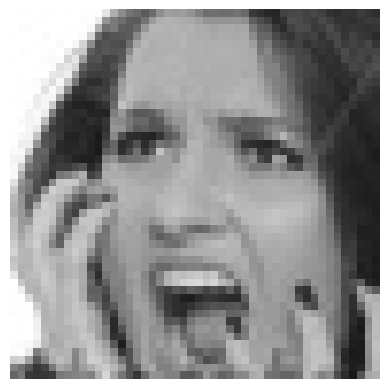

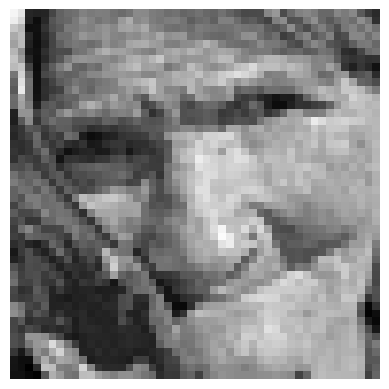

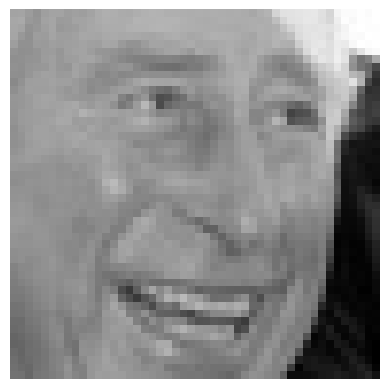

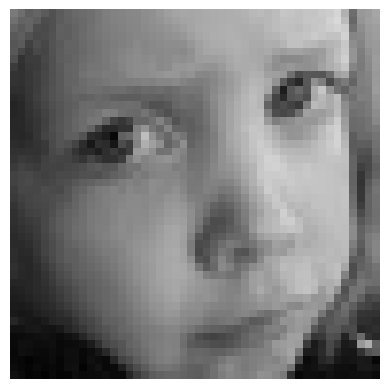

In [52]:
show_first_batch(base_model_max)

Actual:  happy
Predicted:  happy
Actual:  neutral
Predicted:  sad
Actual:  happy
Predicted:  neutral
Actual:  angry
Predicted:  angry
Actual:  happy
Predicted:  fear
Actual:  angry
Predicted:  angry
Actual:  sad
Predicted:  neutral
Actual:  fear
Predicted:  sad
Actual:  sad
Predicted:  angry
Actual:  sad
Predicted:  happy


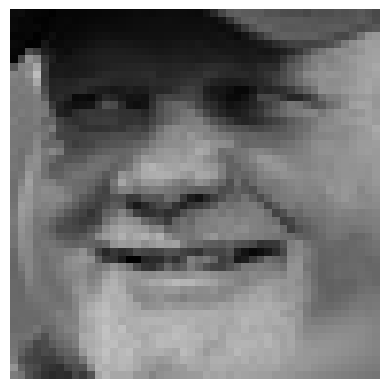

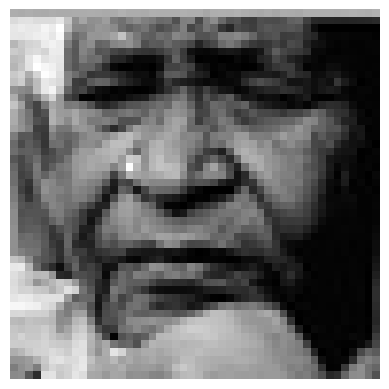

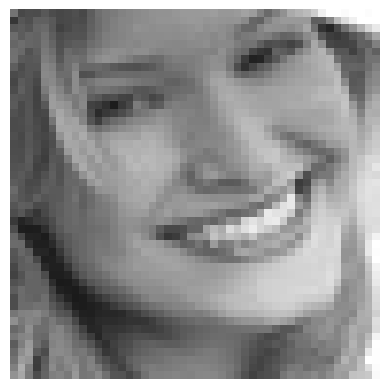

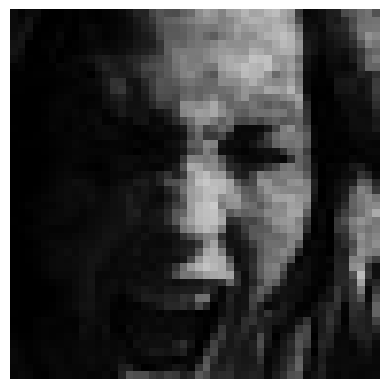

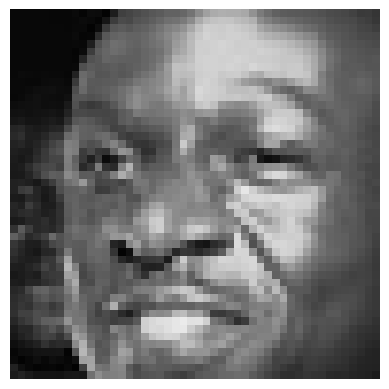

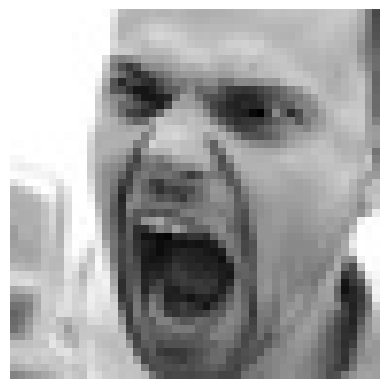

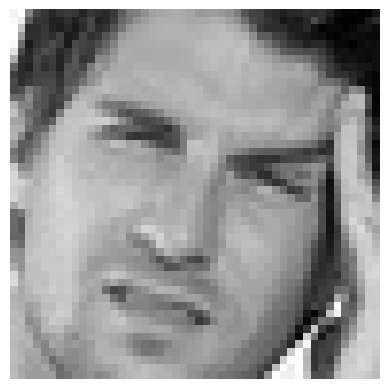

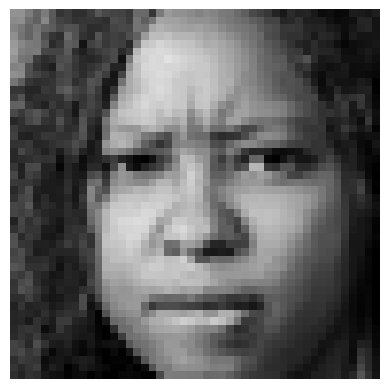

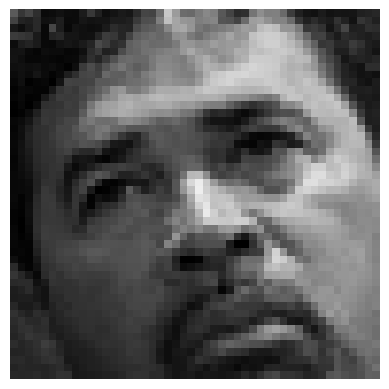

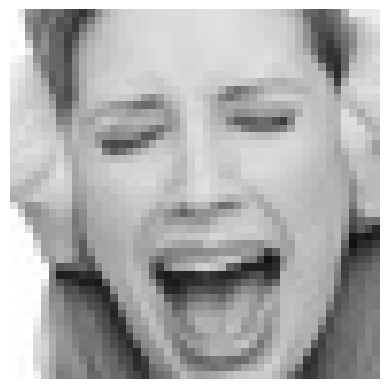

In [53]:
show_first_batch(base_model_avg)

Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  angry
Predicted:  angry
Actual:  happy
Predicted:  angry
Actual:  neutral
Predicted:  neutral
Actual:  surprise
Predicted:  angry
Actual:  angry
Predicted:  angry
Actual:  sad
Predicted:  angry
Actual:  neutral
Predicted:  angry
Actual:  angry
Predicted:  angry


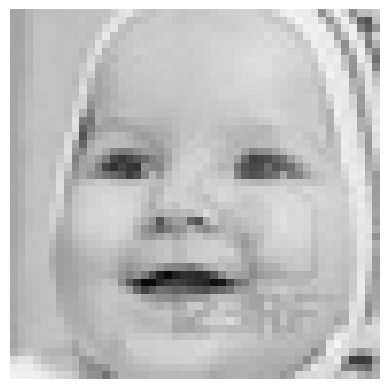

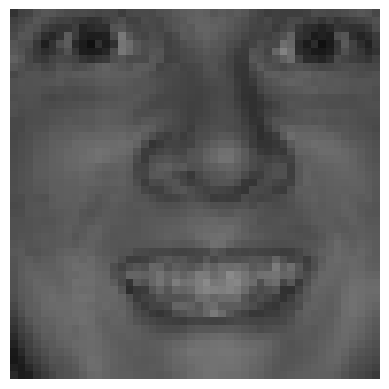

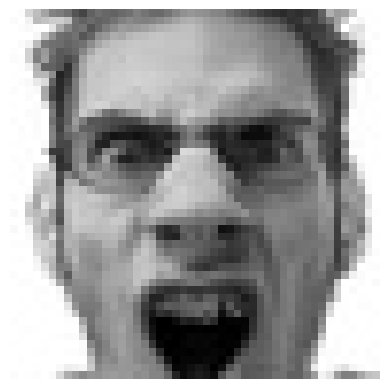

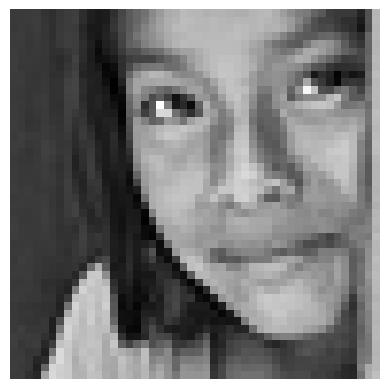

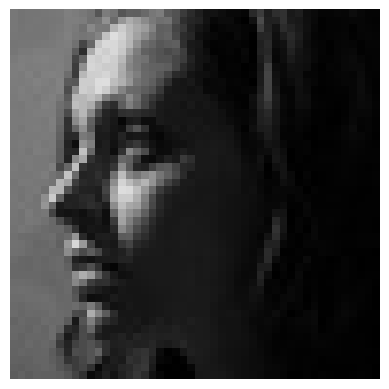

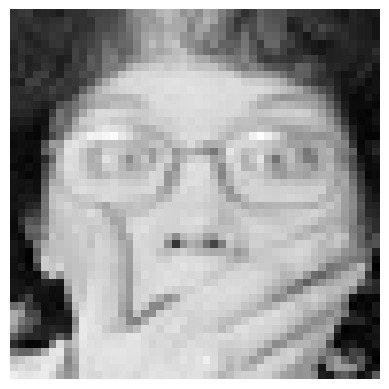

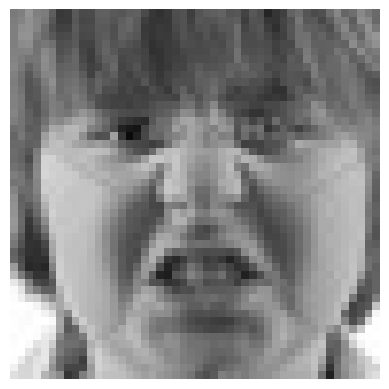

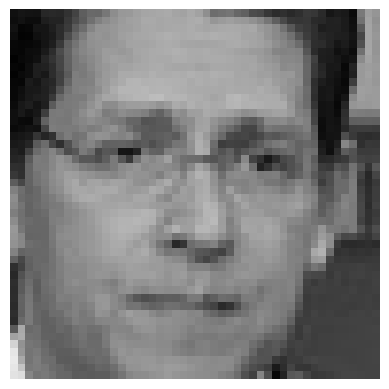

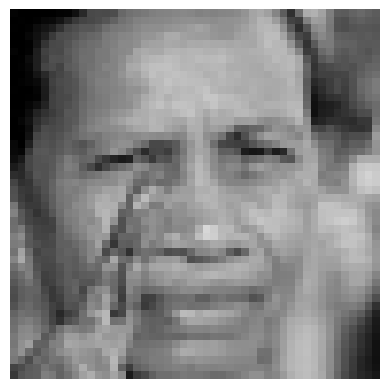

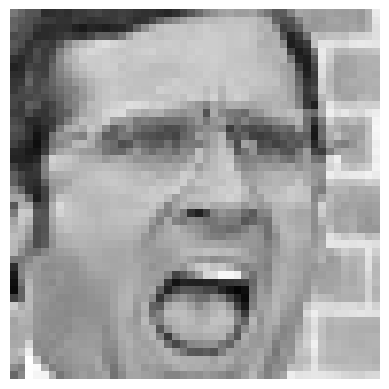

In [54]:
show_first_batch(strong_model)

Actual:  angry
Predicted:  angry
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  happy
Predicted:  happy
Actual:  sad
Predicted:  sad
Actual:  surprise
Predicted:  surprise
Actual:  fear
Predicted:  fear
Actual:  sad
Predicted:  angry


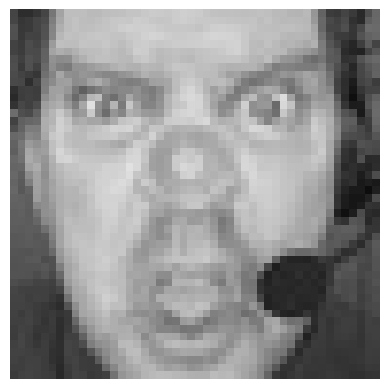

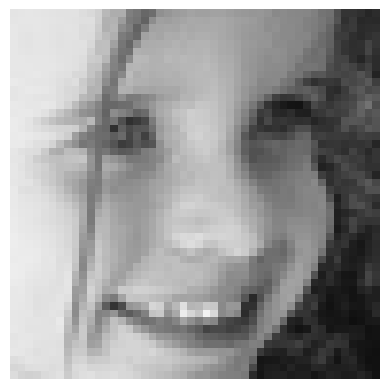

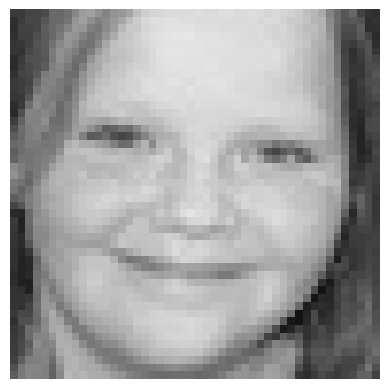

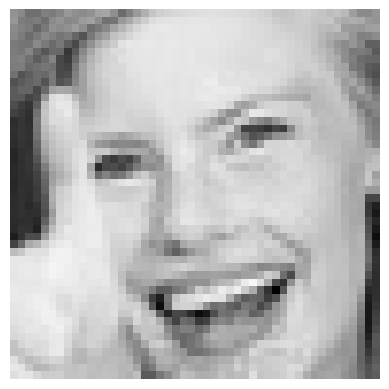

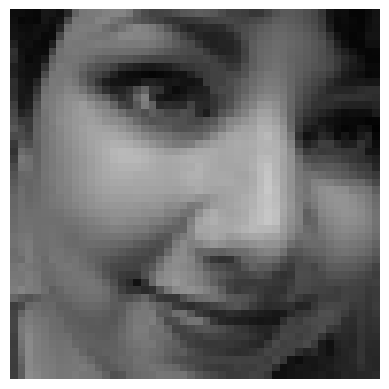

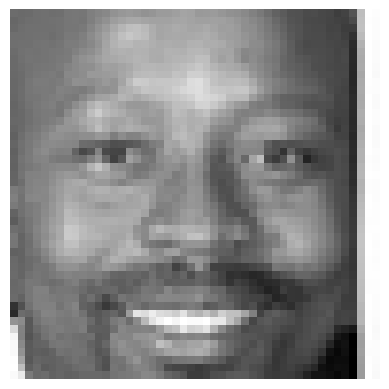

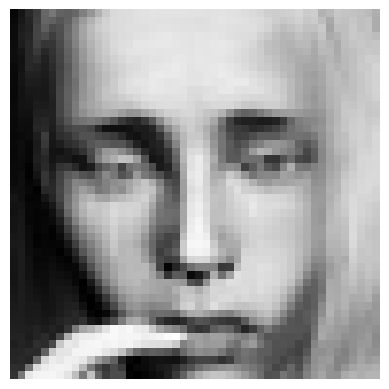

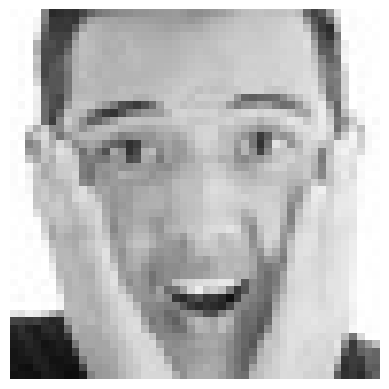

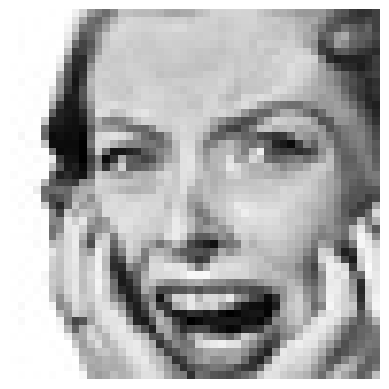

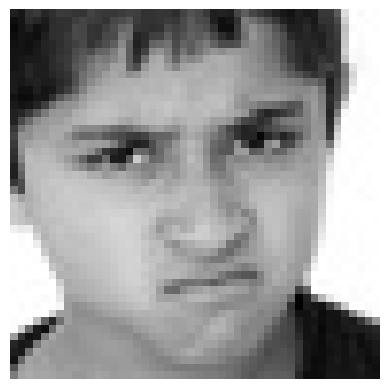

In [55]:
show_first_batch(strongest_model)

## Findings:
We can see that the models did well with certain emotions, and poorly with others. The emotion sad and angry were particular emotions that the model had difficulty working with. Happy is something that the model did particularly well with. We can conclude that expression classification is a difficult task 

Below is a sample script that You can use to pass in a photo, which will automatically detect faces, and save them locally. We can then take those images and feed them into our CNN model.

This code is taken from and modified from: 
'https://www.digitalocean.com/community/tutorials/how-to-detect-and-extract-faces-from-an-image-with-opencv-and-python'

import cv2
import sys


def extract_faces(imagePath):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(48, 48)
    )

    print("[INFO] Found {0} Faces.".format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi_color = image[y:y + h, x:x + w]
        print("[INFO] Object found. Saving locally.")
        cv2.imwrite(str(w) + str(h) + '_faces.jpg', roi_color)

    status = cv2.imwrite('faces_detected.jpg', image)
    print("[INFO] Image faces_detected.jpg written to filesystem: ", status)